In [1]:
# # COCO数据集下载，断点可以按照现有文件继续下载后续内容。

# import os
# import requests

# def download_file(url, local_filename):
#     # 如果文件已经存在，确定其大小
#     if os.path.exists(local_filename):
#         # 获取已下载文件的大小
#         downloaded_size = os.path.getsize(local_filename)
#     else:
#         downloaded_size = 0

#     # 如果文件存在且大小不为0，则设置Range头进行断点续传
#     headers = {}
#     if downloaded_size:
#         headers = {'Range': f'bytes={downloaded_size}-'}

#     with requests.get(url, stream=True, headers=headers) as r:
#         # 检查服务器是否支持范围请求
#         if downloaded_size and r.status_code == 416:
#             print(f"{local_filename} already fully downloaded.")
#             return local_filename

#         r.raise_for_status()

#         # 以追加模式打开文件
#         mode = 'ab' if downloaded_size else 'wb'
#         with open(local_filename, mode) as f:
#             for chunk in r.iter_content(chunk_size=8192):
#                 if chunk:  # 过滤掉保持连接的空块
#                     f.write(chunk)
#                     # 更新已下载的文件大小
#                     downloaded_size += len(chunk)
#                     print(f"Downloaded {downloaded_size} bytes of {local_filename}")

#     return local_filename

# # 下载 COCO 数据集
# urls = [
#     # 'http://images.cocodataset.org/zips/train2017.zip',
#     # 'http://images.cocodataset.org/zips/val2017.zip',
#     'http://images.cocodataset.org/zips/test2017.zip',
#     # 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
# ]

# for url in urls:
#     filename = os.path.join(os.getcwd(), os.path.basename(url))
#     print(f'Downloading {filename}...')
#     download_file(url, filename)
#     print(f'{filename} downloaded successfully.')


In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2

In [3]:
class COCOColorizationDataset(Dataset): # Dataset：PyTorch 提供的 Dataset 基类用于定义自定义数据集类
    def __init__(self, image_dir, transform=None): # transform：可选的数据转换和预处理操作。可以传入 torchvision.transforms 定义的转换操作。
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load color image
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        img_color = Image.open(img_path).convert('RGB') # 使用 Image.open 加载图像
        
        # Convert color image to grayscale
        img_gray = img_color.convert('L') # 将彩色图像转换为灰度图（单通道）输入  灰度图像作为模型的输入（L 通道）。
        
        # Apply transformations
        if self.transform:
            img_color = self.transform(img_color)  # For Lab conversion
            img_gray = self.transform(img_gray)    # For grayscale input
        
        # Convert color image (in RGB) to Lab color space
        img_color_np = np.array(img_color * 255, dtype=np.uint8).transpose(1, 2, 0)  # Convert tensor back to uint8
        img_lab = cv2.cvtColor(img_color_np, cv2.COLOR_RGB2Lab) # 使用 cv2.cvtColor 将 RGB 图像转换为 Lab 色彩空间
        
        # Split into L, a, b channels
        L_channel = img_lab[:, :, 0] / 255.0  # Normalize L to [0, 1]
        a_channel = img_lab[:, :, 1] / 255.0 - 0.5  # Normalize a to [-0.5, 0.5]
        b_channel = img_lab[:, :, 2] / 255.0 - 0.5  # Normalize b to [-0.5, 0.5]
        
        # Convert grayscale and Lab channels to tensors
        L_input = torch.from_numpy(np.array(img_gray) / 255.0).float()  # Grayscale input
        click_mask = torch.zeros_like(L_input)  # Zero mask for click channel
        L_input = torch.cat([L_input, click_mask], dim=0)  # Concatenate to form 2 channels
        
        L_channel = torch.from_numpy(L_channel).unsqueeze(0).float()  # Target L channel
        a_channel = torch.from_numpy(a_channel).unsqueeze(0).float()
        b_channel = torch.from_numpy(b_channel).unsqueeze(0).float()
        
        return L_input, L_channel, a_channel, b_channel

In [4]:
# Set directories and parameters
image_dir = 'val2017'
batch_size = 4

# Data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize for consistency
    transforms.ToTensor()
])

# Create dataset and data loader
dataset = COCOColorizationDataset(image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check dataset output shapes
for L_input, L_target, a, b in dataloader:
    print("Grayscale input L channel shape:", L_input.shape)  # [batch_size, 1, 256, 256]
    print("Target L channel shape:", L_target.shape)          # [batch_size, 1, 256, 256]
    print("a channel shape:", a.shape)                        # [batch_size, 1, 256, 256]
    print("b channel shape:", b.shape)                        # [batch_size, 1, 256, 256]
    break

Grayscale input L channel shape: torch.Size([4, 2, 256, 256])
Target L channel shape: torch.Size([4, 1, 256, 256])
a channel shape: torch.Size([4, 1, 256, 256])
b channel shape: torch.Size([4, 1, 256, 256])


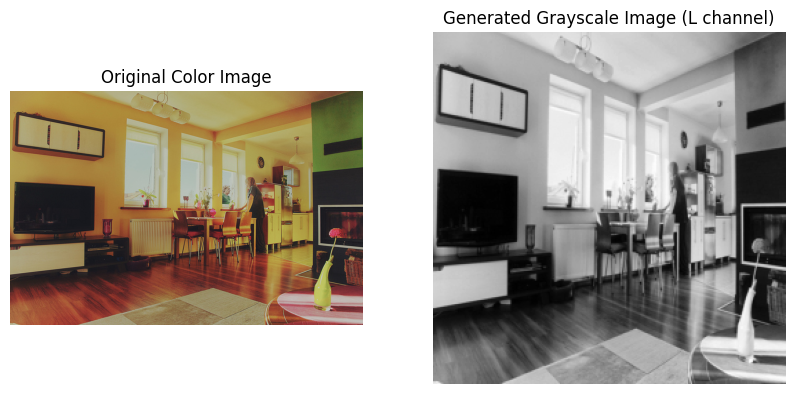

In [5]:
import matplotlib.pyplot as plt

# 取出数据集中的一个示例
example_index = 0
L_input, L_target, a, b = dataset[example_index]

# 将张量转回 NumPy 数组进行可视化
L_input_np = L_input.squeeze(0).numpy()  # 灰度图的 L 通道
L_target_np = L_target.squeeze(0).numpy()  # 彩色图的目标 L 通道

# 转换彩色图像到 RGB 格式以显示
img_path = os.path.join(image_dir, dataset.image_files[example_index])
img_color = Image.open(img_path).convert('RGB')

# 将 L_input_np 的第一个通道提取出来
L_input_np_single = L_input_np[0, :, :]  # 提取灰度图的 L 通道

# 显示彩色图像和对应的灰度图
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_color)
axes[0].set_title("Original Color Image")
axes[0].axis("off")

axes[1].imshow(L_input_np_single, cmap='gray')
axes[1].set_title("Generated Grayscale Image (L channel)")
axes[1].axis("off")

plt.show()

plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, input_channels=2, output_channels=2):
        super(UNet, self).__init__()
        
        # Define the encoder part of the U-Net
        # U-Net 的编码器部分由多个卷积块（conv_block）构成，每个卷积块后接一个池化层，编码器部分的输出特征逐渐缩小，但特征深度逐渐增加。
        # 编码器的每一层输出通道数逐渐增大（64→128→256→512），这逐渐提取更高层的图像特征，适应从局部到全局的特征提取需求。
        self.encoder1 = self.conv_block(input_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        # Bottleneck layer
        # 负责提取图片的深层次特征
        self.bottleneck = self.conv_block(512, 1024)
        
        # Define the decoder part of U-Net
        # 解码器用于将编码器提取的深层次特征逐步还原成较浅的分辨率特征图，使模型输出的预测图像与输入图像在分辨率上保持一致。
        # ConvTranspose2d 实现反卷积操作，使特征图的分辨率逐层增大。
        # decoder4 用来进一步对上采样后的特征进行卷积和激活操作。
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)
        
        # 最后一层输出
        # 这里 output_layer 将解码器的输出转化为指定通道数（即 a 和 b）。
        # kernel_size=1 表示使用 1x1 卷积核，输出的每个像素点直接映射到 a 和 b 通道上，保持图像尺寸不变。
        self.output_layer = nn.Conv2d(64, output_channels, kernel_size=1)


    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            # BatchNorm2d：批归一化层，提高模型收敛速度和稳定性。
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    

    def forward(self, x):
        # 编码器部分
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))
        
        # 底部层
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        
        # 解码器部分
        dec4 = self.upconv4(bottleneck)
        # torch.cat((dec4, enc4), dim=1)：跳跃连接（Skip Connection），将编码器的特征图拼接到解码器特征图上，以保留更多图像细节。
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        # 输出预测的 a 和 b 通道
        output = self.output_layer(dec1)
        return output

In [7]:
# 测试模型的输出形状
input_channels = 2  # 输入通道数，包含灰度图像 (L) 和点击掩码
output_channels = 2  # 输出通道数，预测的 a 和 b

# 创建 U-Net 模型
model = UNet(input_channels=input_channels, output_channels=output_channels)

# 检查模型输出形状
x = torch.randn(1, 2, 256, 256)  # batch_size=1, 输入通道数=2, 图像大小=256x256
output = model(x)
print("输出形状:", output.shape)  # 期望输出形状为 [1, 2, 256, 256]

输出形状: torch.Size([1, 2, 256, 256])


In [8]:
import torch.optim as optim
from tqdm import tqdm  # 用于显示训练进度
from torch.amp import GradScaler, autocast  # 新增

In [9]:
num_epochs = 50  # 训练的迭代次数
learning_rate = 0.001  # 学习率
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 选择设备

# Mean Squared Error (MSE) 作为损失函数
criterion = nn.MSELoss()

# Adam 优化器
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 初始化混合精度缩放器
scaler = GradScaler()  # 新增

# 数据增强
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# 创建数据集和数据加载器
train_dataset = COCOColorizationDataset(image_dir='val2017', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)



In [11]:
import gc
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# 将模型转移到 GPU（若可用）
model = model.to(device)

# 开始训练
for epoch in range(num_epochs):
    gc.collect()
    torch.cuda.empty_cache()
    model.train()  # 设置模型为训练模式
    running_loss = 0.0  # 记录每个 epoch 的总损失
    
    # 使用 tqdm 显示训练进度
    for L_input, L_target, a, b in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # 将数据转移到 GPU（若可用）
        L_input = L_input.to(device)
        a = a.to(device)
        b = b.to(device)
        
        # 清零梯度
        optimizer.zero_grad()
        
        
        with autocast(device_type='cuda'):  
            # 前向传播
            outputs = model(L_input)
            predicted_a, predicted_b = outputs[:, 0, :, :], outputs[:, 1, :, :]
        
            # 计算损失
            loss_a = criterion(predicted_a, a)
            loss_b = criterion(predicted_b, b)
            loss = loss_a + loss_b
        
        # 反向传播并更新权重
        # loss.backward()
        scaler.scale(loss).backward()
        # optimizer.step()
        scaler.step(optimizer)
        scaler.update()  # 更新缩放因子
        
        # 更新总损失
        running_loss += loss.item()
    
    # 每个 epoch 结束后打印平均损失
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch 1/50:   0%|          | 0/1250 [00:00<?, ?it/s]C:\Users\江睿达\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([4, 1, 256, 256])) that is different to the input size (torch.Size([4, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/50: 100%|██████████| 1250/1250 [03:54<00:00,  5.32it/s]


Epoch [1/50], Loss: 0.0087


Epoch 2/50: 100%|██████████| 1250/1250 [03:55<00:00,  5.30it/s]


Epoch [2/50], Loss: 0.0073


Epoch 3/50: 100%|██████████| 1250/1250 [03:56<00:00,  5.30it/s]


Epoch [3/50], Loss: 0.0073


Epoch 4/50: 100%|██████████| 1250/1250 [03:56<00:00,  5.29it/s]


Epoch [4/50], Loss: 0.0072


Epoch 5/50: 100%|██████████| 1250/1250 [03:56<00:00,  5.28it/s]


Epoch [5/50], Loss: 0.0071


Epoch 6/50: 100%|██████████| 1250/1250 [03:56<00:00,  5.29it/s]


Epoch [6/50], Loss: 0.0071


Epoch 7/50: 100%|██████████| 1250/1250 [03:56<00:00,  5.30it/s]


Epoch [7/50], Loss: 0.0071


Epoch 8/50: 100%|██████████| 1250/1250 [03:59<00:00,  5.21it/s]


Epoch [8/50], Loss: 0.0070


Epoch 9/50: 100%|██████████| 1250/1250 [03:59<00:00,  5.22it/s]


Epoch [9/50], Loss: 0.0070


Epoch 10/50: 100%|██████████| 1250/1250 [03:55<00:00,  5.32it/s]


Epoch [10/50], Loss: 0.0069


Epoch 11/50: 100%|██████████| 1250/1250 [03:58<00:00,  5.25it/s]


Epoch [11/50], Loss: 0.0070


Epoch 12/50: 100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


Epoch [12/50], Loss: 0.0071


Epoch 13/50: 100%|██████████| 1250/1250 [03:55<00:00,  5.31it/s]


Epoch [13/50], Loss: 0.0070


Epoch 14/50: 100%|██████████| 1250/1250 [03:53<00:00,  5.34it/s]


Epoch [14/50], Loss: 0.0071


Epoch 15/50: 100%|██████████| 1250/1250 [03:56<00:00,  5.29it/s]


Epoch [15/50], Loss: 0.0070


Epoch 16/50: 100%|██████████| 1250/1250 [03:54<00:00,  5.32it/s]


Epoch [16/50], Loss: 0.0070


Epoch 17/50: 100%|██████████| 1250/1250 [03:59<00:00,  5.22it/s]


Epoch [17/50], Loss: 0.0070


Epoch 18/50: 100%|██████████| 1250/1250 [04:00<00:00,  5.19it/s]


Epoch [18/50], Loss: 0.0071


Epoch 19/50: 100%|██████████| 1250/1250 [04:01<00:00,  5.17it/s]


Epoch [19/50], Loss: 0.0070


Epoch 20/50: 100%|██████████| 1250/1250 [04:02<00:00,  5.15it/s]


Epoch [20/50], Loss: 0.0071


Epoch 21/50: 100%|██████████| 1250/1250 [04:04<00:00,  5.12it/s]


Epoch [21/50], Loss: 0.0070


Epoch 22/50: 100%|██████████| 1250/1250 [04:02<00:00,  5.16it/s]


Epoch [22/50], Loss: 0.0070


Epoch 23/50: 100%|██████████| 1250/1250 [04:03<00:00,  5.14it/s]


Epoch [23/50], Loss: 0.0070


Epoch 24/50: 100%|██████████| 1250/1250 [04:02<00:00,  5.16it/s]


Epoch [24/50], Loss: 0.0071


Epoch 25/50: 100%|██████████| 1250/1250 [04:02<00:00,  5.16it/s]


Epoch [25/50], Loss: 0.0070


Epoch 26/50: 100%|██████████| 1250/1250 [04:03<00:00,  5.14it/s]


Epoch [26/50], Loss: 0.0070


Epoch 27/50: 100%|██████████| 1250/1250 [04:02<00:00,  5.16it/s]


Epoch [27/50], Loss: 0.0070


Epoch 28/50: 100%|██████████| 1250/1250 [04:02<00:00,  5.15it/s]


Epoch [28/50], Loss: 0.0071


Epoch 29/50: 100%|██████████| 1250/1250 [04:00<00:00,  5.21it/s]


Epoch [29/50], Loss: 0.0070


Epoch 30/50: 100%|██████████| 1250/1250 [04:00<00:00,  5.20it/s]


Epoch [30/50], Loss: 0.0071


Epoch 31/50: 100%|██████████| 1250/1250 [04:00<00:00,  5.19it/s]


Epoch [31/50], Loss: 0.0069


Epoch 32/50: 100%|██████████| 1250/1250 [03:57<00:00,  5.27it/s]


Epoch [32/50], Loss: 0.0070


Epoch 33/50: 100%|██████████| 1250/1250 [03:55<00:00,  5.31it/s]


Epoch [33/50], Loss: 0.0070


Epoch 34/50: 100%|██████████| 1250/1250 [03:56<00:00,  5.29it/s]


Epoch [34/50], Loss: 0.0070


Epoch 35/50: 100%|██████████| 1250/1250 [03:55<00:00,  5.31it/s]


Epoch [35/50], Loss: 0.0071


Epoch 36/50: 100%|██████████| 1250/1250 [03:58<00:00,  5.24it/s]


Epoch [36/50], Loss: nan


Epoch 37/50: 100%|██████████| 1250/1250 [03:57<00:00,  5.26it/s]


Epoch [37/50], Loss: 0.0070


Epoch 38/50: 100%|██████████| 1250/1250 [03:56<00:00,  5.30it/s]


Epoch [38/50], Loss: 0.0071


Epoch 39/50: 100%|██████████| 1250/1250 [03:54<00:00,  5.34it/s]


Epoch [39/50], Loss: nan


Epoch 40/50: 100%|██████████| 1250/1250 [03:52<00:00,  5.37it/s]


Epoch [40/50], Loss: nan


Epoch 41/50: 100%|██████████| 1250/1250 [03:52<00:00,  5.37it/s]


Epoch [41/50], Loss: nan


Epoch 42/50: 100%|██████████| 1250/1250 [03:52<00:00,  5.37it/s]


Epoch [42/50], Loss: nan


Epoch 43/50: 100%|██████████| 1250/1250 [03:52<00:00,  5.37it/s]


Epoch [43/50], Loss: nan


Epoch 44/50: 100%|██████████| 1250/1250 [03:54<00:00,  5.34it/s]


Epoch [44/50], Loss: nan


Epoch 45/50: 100%|██████████| 1250/1250 [04:03<00:00,  5.13it/s]


Epoch [45/50], Loss: nan


Epoch 46/50: 100%|██████████| 1250/1250 [04:05<00:00,  5.09it/s]


Epoch [46/50], Loss: nan


Epoch 47/50: 100%|██████████| 1250/1250 [04:01<00:00,  5.17it/s]


Epoch [47/50], Loss: nan


Epoch 48/50: 100%|██████████| 1250/1250 [03:59<00:00,  5.23it/s]


Epoch [48/50], Loss: nan


Epoch 49/50: 100%|██████████| 1250/1250 [03:58<00:00,  5.23it/s]


Epoch [49/50], Loss: nan


Epoch 50/50: 100%|██████████| 1250/1250 [03:59<00:00,  5.22it/s]

Epoch [50/50], Loss: nan


In [12]:
# 保存模型参数
torch.save(model.state_dict(), 'colorization_unet.pth')
print("模型已保存至 'colorization_unet.pth'")

模型已保存至 'colorization_unet.pth'


In [ ]:
import torch
print(torch.__version__)

2.5.0+cu121
